In [463]:
import os, glob

import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('precision', 5)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['axes.titlesize'] = 12

In [12]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve, roc_curve, auc, f1_score
from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedKFold

In [27]:
def plot_digit(data, **kwargs):
    image = data.reshape(28, 28)
    plt.figure(figsize=kwargs.get('figsize', (4,4)))
    plt.imshow(image, cmap = plt.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [13]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [14]:
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)
X.shape

(70000, 784)

In [15]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Exercise 1. KNN to achieve over 97% accuracy in test set

KNN is slow to run. Use a subset of data insteaad.

In [40]:
from collections import Counter
Counter(y_train[:2000])

Counter({5: 180,
         0: 191,
         4: 214,
         1: 220,
         9: 210,
         2: 198,
         3: 191,
         6: 200,
         7: 224,
         8: 172})

In [54]:
obs_upto = 5000
X_train_trimmed = X_train[:obs_upto]
y_train_trimmed = y_train[:obs_upto]

In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [56]:
param_grid = [{'n_neighbors': [3,5,7], 'weights': ['uniform', 'distance']}]

knn = KNeighborsClassifier(n_jobs=4)

grid_search = GridSearchCV(knn, param_grid=param_grid, cv=3, verbose=3)
grid_search.fit(X_train_trimmed, y_train_trimmed)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... n_neighbors=3, weights=uniform, score=0.911, total=   2.1s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.932, total=   1.8s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.924, total=   1.8s
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.917, total=   1.8s
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.938, total=   1.8s
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.928, total=   1.8s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ...... n_neighbors=5, weights=uniform, score=0.911, total=   1.8s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ...... n_neighbors=5, weights=uniform, score=0.929, total=   1.9s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ...... n_neighbors=5, weights=uniform, score=0.925, total=   1.9s
[CV] n_neighbors=5, weights=distance .................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   33.6s finished


GridSearchCV(cv=3, estimator=KNeighborsClassifier(n_jobs=4),
             param_grid=[{'n_neighbors': [3, 5, 7],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [57]:
grid_search.best_params_

{'n_neighbors': 3, 'weights': 'distance'}

In [58]:
grid_search.best_score_

0.9278000342308489

In [59]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9379

### Exercise 2. Shift image as data augmentation

In [62]:
from scipy.ndimage.interpolation import shift, rotate

In [120]:
def shift_image(image, move, new=0.0):
    return shift(image.reshape(28, 28), move, cval=new).reshape(784)

def rotate_image(image, angle, new=0.0):
    return rotate(image.reshape(28, 28), angle, cval=new, order=1, reshape=False).reshape(784)

In [151]:
X_train_extended = [X_train]

In [152]:
moves = [(1,0), (-1,0), (0,1), (0,-1)]

for move in moves:
    X_train_extended.append(np.apply_along_axis(shift_image, axis=1, arr=X_train, move=move))

In [153]:
angles = [-10, 10]

for angle in angles:
    X_train_extended.append(np.apply_along_axis(rotate_image, axis=1, arr=X_train, angle=angle))

In [154]:
y_train_extended = np.tile(y_train, len(X_train_extended))
X_train_extended = np.concatenate(X_train_extended)

In [155]:
X_train_extended.shape

(420000, 784)

In [156]:
y_train_extended.shape

(420000,)

In [159]:
np.random.seed(42)
permutation_ids = np.random.permutation(len(X_train))
X_train_extended = X_train_extended[permutation_ids]
y_train_extended = y_train_extended[permutation_ids]

In [162]:
X_train_extended_trimed = X_train_extended[:obs_upto]
y_train_extended_trimed = y_train_extended[:obs_upto]

In [163]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)
knn_clf.fit(X_train_extended_trimed, y_train_extended_trimed)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [165]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9386

In [188]:
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_normed = conf_mat / conf_mat.sum(axis=1, keepdims=True)
np.fill_diagonal(conf_mat_normed, val=0)

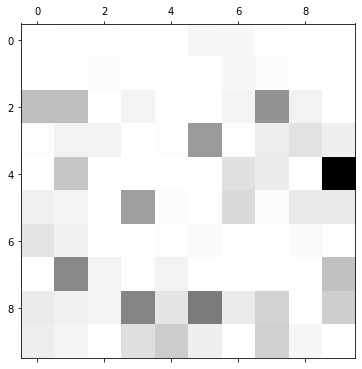

In [189]:
plt.matshow(conf_mat_normed, cmap='Greys')

### 3. Tackle the Titanic dataset

#### Load data

In [203]:
TITANIC_PATH = os.path.join("/Users/huishi/Learning_DS/handson-ml2/datasets", "titanic")

In [197]:
#os.makedirs("/Users/huishi/Learning_DS/handson-ml2/datasets/titanic")

In [204]:
def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [205]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")
complete_data = np.c

In [207]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Take a look

In [210]:
train_data.shape

(891, 12)

In [272]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Is data imbalanced?

In [418]:
pd.value_counts(train_data['Survived'])

0    549
1    342
Name: Survived, dtype: int64

In [367]:
train_data.isnull().sum(axis=0) / len(train_data)

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

Age is null for some survivors.

In [342]:
pd.crosstab(train_data['Survived'], train_data['Age'].isnull())

Age,False,True
Survived,,
0,424,125
1,290,52


In [213]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [214]:
train_data.describe(include='O')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Risien, Mr. Samuel Beard",male,CA. 2343,G6,S
freq,1,577,7,4,644


In [268]:
def survive_rate_by_cat_feature(df, metric):
    return df[[metric, 'Survived']].groupby(metric).Survived.agg(['mean', 'count']).sort_values('mean', ascending=False)

In [326]:
agg_list = []
for metric in ['Sex', 'Embarked', 'Pclass']:
    agg_list.append(survive_rate_by_cat_feature(train_data, metric))

In [327]:
agg_list

[            mean  count
 Sex                    
 female  0.742038    314
 male    0.188908    577,
               mean  count
 Embarked                 
 C         0.553571    168
 Q         0.389610     77
 S         0.336957    644,
             mean  count
 Pclass                 
 1       0.629630    216
 2       0.472826    184
 3       0.242363    491]

In [281]:
train_data.Cabin.str.extract(pat='^([a-zA-Z]*)', expand=False).dropna().value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin, dtype: int64

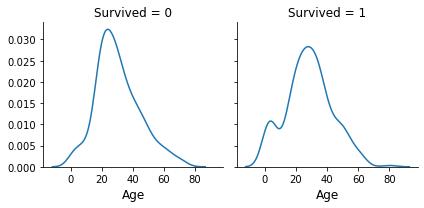

In [300]:
g = sns.FacetGrid(train_data, col='Survived')
g.map(sns.kdeplot, 'Age')

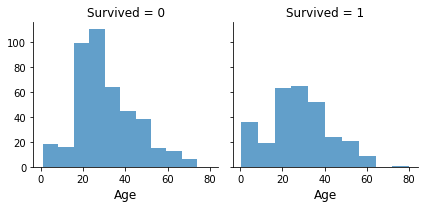

In [314]:
g = sns.FacetGrid(train_data, col='Survived')
g.map(plt.hist, 'Age', alpha=0.7)

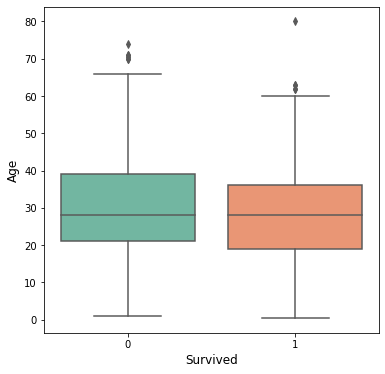

In [312]:
sns.boxplot(y='Age', x='Survived', data=train_data, palette='Set2')

#### Feature transformation

In [404]:
num_vars = ['Age', 'SibSp', 'Parch', 'Fare']
cat_vars = ['Pclass', 'Sex', 'Embarked']

In [405]:
X_train, X_test = train_data[num_vars + cat_vars], test_data[num_vars + cat_vars]
y_train = train_data['Survived']

Use only cabin class and cast Pclass from int to str.

In [406]:
X_train = X_train.assign(
  #  Cabin = X_train['Cabin'].str.extract('^([a-zA-Z]+)', expand=False),
    Pclass = X_train['Pclass'].astype('str'))

X_test = X_test.assign(
   # Cabin = X_test['Cabin'].str.extract('^([a-zA-Z]+)', expand=False),
    Pclass = X_test['Pclass'].astype('str'))

In [407]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

In [408]:
num_pipeline = Pipeline([
    ('med_imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())]
)

cat_pipeline = Pipeline([
    ('freq_imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())
])

preprocess_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_vars),
    ('cat', cat_pipeline, cat_vars[1:]),
    ('ord', OrdinalEncoder(), ['Pclass'])   # Pclass has a natural order itself
])

label_encoder = LabelEncoder()             # for target variable

In [409]:
X_train_trans = preprocess_pipeline.fit_transform(X_train)
X_test_trans = preprocess_pipeline.transform(X_test)
y_train_trans = label_encoder.fit_transform(y_train)

In [410]:
X_train_trans.shape

(891, 10)

#### Fit two models

In [479]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, auc, precision_recall_curve, roc_curve, roc_auc_score

In [424]:
1e-4

0.0001

In [549]:
log_reg = LogisticRegression(random_state=42)

param_grid_lr = [{"tol": [0.3, 1e-1, 1e-2, 1e-3]}]

grid_search_lr = GridSearchCV(log_reg, param_grid_lr, scoring='accuracy', cv=10)

grid_search_lr.fit(X_train_trans, y_train_trans)

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=42),
             param_grid=[{'tol': [0.3, 0.1, 0.01, 0.001]}], scoring='accuracy')

In [562]:
cv_results_lr = pd.DataFrame(grid_search_lr.cv_results_).sort_values('mean_test_score', ascending=False)
cv_results_lr

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.00548,0.00085,0.00031,7.93318e-05,0.3,{'tol': 0.3},0.8,0.79775,0.75281,0.80899,0.78652,0.77528,0.78652,0.78652,0.80899,0.83146,0.79348,0.02029,1
1,0.00564,0.00034,0.00027,2.47122e-05,0.1,{'tol': 0.1},0.8,0.79775,0.75281,0.80899,0.78652,0.76404,0.78652,0.78652,0.80899,0.83146,0.79236,0.02154,2
2,0.00595,0.00041,0.00024,3.20369e-06,0.01,{'tol': 0.01},0.8,0.79775,0.75281,0.80899,0.78652,0.76404,0.78652,0.78652,0.80899,0.83146,0.79236,0.02154,2
3,0.00627,0.00077,0.00028,7.17894e-05,0.001,{'tol': 0.001},0.8,0.79775,0.75281,0.80899,0.78652,0.76404,0.78652,0.78652,0.80899,0.83146,0.79236,0.02154,2


In [541]:
grid_search_lr.best_score_

0.7934831460674158

In [551]:
gbc = GradientBoostingClassifier(random_state=42)

param_grid_gbc = [{"learning_rate":[0.3, 0.1, 0.03], "n_estimators": [50,100,200], "max_features": ["log2", 0.6, None]}]

grid_search_gbc = GridSearchCV(gbc, param_grid_gbc, scoring='accuracy', cv=10)

grid_search_gbc.fit(X_train_trans, y_train_trans)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=42),
             param_grid=[{'learning_rate': [0.3, 0.1, 0.03],
                          'max_features': ['log2', 0.6, None],
                          'n_estimators': [50, 100, 200]}],
             scoring='accuracy')

In [560]:
cv_results_gbc = pd.DataFrame(grid_search_gbc.cv_results_).sort_values('mean_test_score', ascending=False)
cv_results_gbc.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
11,0.12830,0.00091,0.00080,0.00002,0.1,log2,200,"{'learning_rate': 0.1, 'max_features': 'log2', 'n_estimators': 200}",0.81111,0.83146,0.75281,0.86517,0.91011,0.84270,0.86517,0.78652,0.86517,0.83146,0.83617,0.04257,1
14,0.14715,0.00174,0.00083,0.00003,0.1,0.6,200,"{'learning_rate': 0.1, 'max_features': 0.6, 'n_estimators': 200}",0.81111,0.82022,0.75281,0.87640,0.88764,0.87640,0.83146,0.78652,0.86517,0.84270,0.83504,0.04132,2
6,0.04337,0.00043,0.00058,0.00005,0.3,None,50,"{'learning_rate': 0.3, 'max_features': None, 'n_estimators': 50}",0.82222,0.82022,0.75281,0.86517,0.87640,0.88764,0.84270,0.77528,0.86517,0.83146,0.83391,0.04131,3


In [553]:
grid_search_gbc.best_estimator_

GradientBoostingClassifier(max_features='log2', n_estimators=200,
                           random_state=42)

In [468]:
grid_search_gbc.best_score_

0.8383781763826607

#### performance and error analysis

In [474]:
y_train_pred = grid_search_gbc.predict_proba(X_train_trans)[:,1]

**Precision and Recall**

In [515]:
precisions, recalls, thresholds = precision_recall_curve(y_train_trans, y_train_pred)

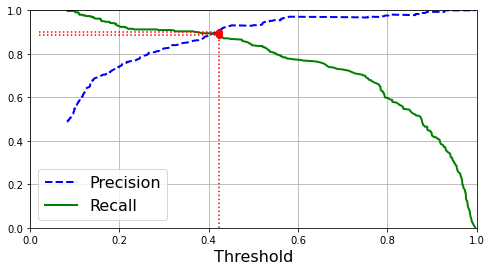

In [519]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="lower left", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([0, 1, 0, 1])             # Not shown


# when precision is 90%, what are the recall and threshold?
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([0.02, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([0.02, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

In [522]:
threshold_precision_90 = thresholds[np.argmax(precision>0.9)]

In [529]:
recall_90_precision, threshold_90_precision, threshold_precision_90

(0.8888888888888888, 0.42298277266409173, 0.42298277266409173)

In [524]:
y_train_pred_v2 = y_train_pred >= threshold_precision_90

In [525]:
precision_score(y_train_trans, y_train_pred_v2)

0.9020771513353115

In [526]:
recall_score(y_train_trans, y_train_pred_v2)

0.8888888888888888

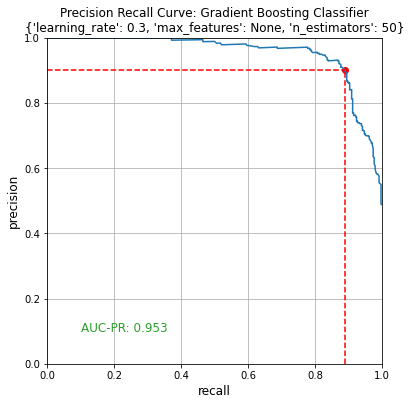

In [537]:
plt.plot(recall, precision)
plt.xlabel("recall")
plt.ylabel("precision")
plt.title(f'Precision Recall Curve: Gradient Boosting Classifier\n{grid_search_gbc.best_params_}')
plt.scatter(x=recall_90_precision, y=0.9, c='r')
plt.plot([0, recall_90_precision], [0.9, 0.9], 'r--')
plt.plot([recall_90_precision, recall_90_precision], [0, 0.9], 'r--')
plt.axis([0,1,0,1])
plt.text(0.1, 0.1, s=f"AUC-PR: {auc(recall, precision):.3f}", fontsize=12, color='C2')
plt.grid(True)

**ROC**

In [492]:
fpr, tpr, thresholds = roc_curve(y_train_trans, y_train_pred)

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([fpr_90_tpr, fpr_90_tpr], [0., recall_90_precision], "r:") # Not shown
plt.plot([0.0, fpr_90_tpr], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90_tpr], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                         # Not shown
plt.show()

Text(0.5, 1.0, "ROC: Gradient Boosting Classifier\n{grid_search_gbc.best_params_}')")

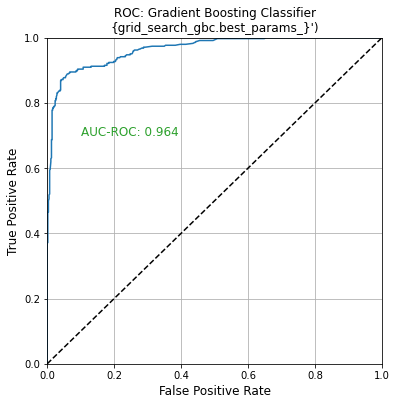

In [499]:
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], 'k--')
plt.axis([0,1,0,1])
plt.text(0.1, 0.7, s=f"AUC-ROC: {roc_auc_score(y_train_trans, y_train_pred):.3f}", fontsize=12, color='C2')
plt.grid(True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC: Gradient Boosting Classifier\n{grid_search_gbc.best_params_}')")

**boxplot for cv 10 fold split test**

In [577]:
lr_scores = cv_results_lr.filter(regex='split[0-9]+_test_score', axis=1).head(1).values.flatten()
gbc_scores = cv_results_gbc.filter(regex='split[0-9]+_test_score', axis=1).head(1).values.flatten()

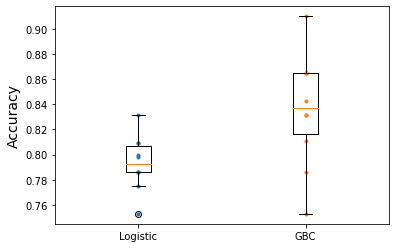

In [580]:
plt.figure(figsize=(6, 4))
plt.plot([1]*10, lr_scores, ".")
plt.plot([2]*10, gbc_scores, ".")
plt.boxplot([lr_scores, gbc_scores], labels=("Logistic","GBC"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()